## Model

In [5]:
using BenchmarkTools, Revise, Plots, Revise, ReachabilityAnalysis
const RA = ReachabilityAnalysis

┌ Info: Precompiling ReachabilityAnalysis [1e97bd63-91d1-579d-8e8d-501d2b57c93f]
└ @ Base loading.jl:1260


ReachabilityAnalysis

Consider the discrete post-operator associated to the transition from outside the ball to its interior,

$$
post_d(X) = (R(X ∩ G ∩ I⁻) ⊕ W) ∩ I⁺
$$

In this problem the reset map is the identity, so the equation above simplifies to

$$
post_d(X) = X ∩ G ∩ I⁻ ∩ I⁺
$$

Let `B` be the ball in the 2-norm with center `[1.0, 1.0]` and radius `1.5`. For correctness using this `B` as a nonlinear guard, we compute `B_ext` (`B_int`), an over (under) approximation of `B`. Below we plot such approximations. For illustration with the rest of the notebook we use exaggerately big approximation errors.

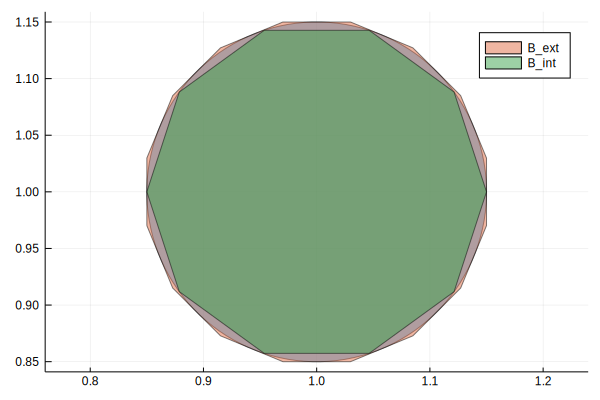

In [6]:
B = Ball2([1.0, 1.0], 0.15);
B_ext = overapproximate(B, 1e-2)
B_int = underapproximate(B, PolarDirections(10))

plot(B, 1e-4)
plot!(B_ext, lab="B_ext")
plot!(B_int, ratio=1, lab="B_int")

In [13]:
B_int = tohrep(convert(VPolygon, B_int)) # cast to Hrep

I⁻ = complement(B_int) # source invariant
I⁺ = B_ext # target invariant
G = B_ext # guard

transition = DiscreteTransition(guard=G, source_invariant=I⁻, target_invariant=I⁺);

----

In [8]:
@taylorize function lotka_volterra!(du, u, p, t)
    du[1] = u[1] * (3.0 - 3.0*u[2])
    du[2] = -u[2] * (1.0 - 1.0*u[1])
    return du
end

In [9]:
ε = 0.008
X0 = Hyperrectangle(low=[1.3-ε, 1.], high=[1.3+ε, 1.]);

In [17]:
prob = @ivp(x' = lotka_volterra!(x), dim: 2, x(0) ∈ X0);
sol = solve(prob, tspan=(0.0, 3.64), TMJets(abs_tol=1e-17,orderT=7,orderQ=1));
solz = overapproximate(sol, Zonotope);

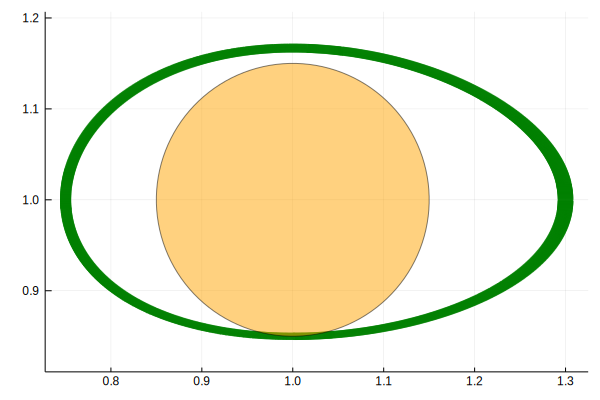

In [215]:
fig = plot()
plot!(fig, sol1z,  vars=(1, 2), linecolor=:green, color=:green, alpha=0.8, ratio=1.0)
plot!(B, 1e-4, color=:orange)

Next we identify the sets which intersect the guard.

In [216]:
using ReachabilityAnalysis: _is_intersection_empty
LazySets.set_ztol(Float64, 1e-14)

L = Vector{ReachSet{Float64, setrep(solz)}}()
for X in solz
    _is_intersection_empty(X, G) && continue
    push!(L, X)
end
length(L)

71

The amount of time integrated inside the ball, ($c_{cnt}$) corrsponds to the width of the time span of `L`:

In [217]:
tspan(L)

[2.65398, 2.85078]

In [218]:
diam(ans)

0.19679180265730523

Below we visualize the sets in `L`. Recall that we are using a bad approximation of `G` (on purpose).

For instance, we see that some sets intersect `G` but do not intersect the better approximation of the exact ball, that we have called `B`.

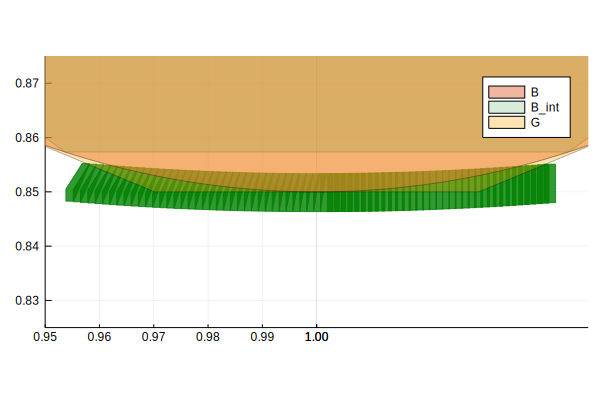

In [219]:
fig = plot()
plot!(fig, L, vars=(1, 2), linecolor=:green, color=:green, alpha=0.8, ratio=1.0)
plot!(B, 1e-5, lab="B")
plot!(B_int, lab="B_int", alpha=.2)
plot!(G, lab="G", ylims=(0.825, 0.875), xlims=(0.95, 1.05), color=:orange, alpha=.3)

Since we found more than one set, that intersects the guard set, we will adopt the usual strategy of clustering, see e.g. [[FR12]](https://juliareach.github.io/ReachabilityAnalysis.jl/dev/references/#[FR12]-1).

Moreover, since `TMJets` receives an initial box, it is reasonable to overapproximate the cluster with a box, then apply the reset map. The result will no longer be box, and we will again overapprximate with a box in the continuous post. However this last approximation is already done inside the continuous post.

In [220]:
Lhull = Convexify(L);

In [221]:
Lhull_box = overapproximate(Lhull, Hyperrectangle);

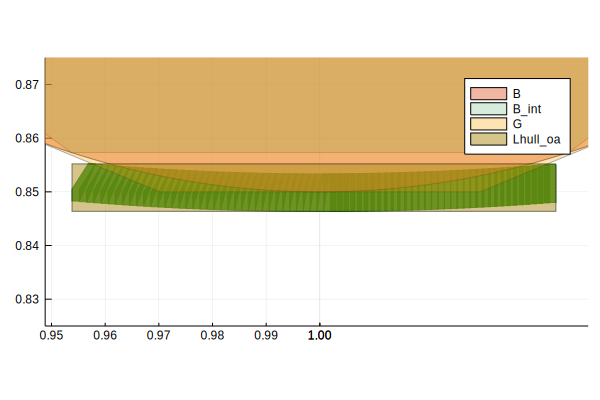

In [222]:
plot!(Lhull_box, vars=(1, 2), lab="Lhull_oa", alpha=.5)

We now apply the transition to `Lhull_oa`, and feed the result to the algorithm in the second location (which has the same dynamics).

The set `X0new` defined below is the set after applying the transition.

In [223]:
method = RA.HRepIntersection()
X0new = apply(transition, Lhull_box, method);

It should be noted that the source invariant is not convex; for the above method to work we extended some methods from `LazySets` to deal with non-convex sets. The idea is the following:

- Let $X ∩ G ∩ I⁻ ∩ I⁺$ with $X$ a polytope, $G$ a polytope, $I⁺$ a polytope, and $I⁻$ the complement of a polytope that we represent as the set union of half-spaces:

In [226]:
typeof(source_invariant(transition))

UnionSetArray{Float64,HalfSpace{Float64,Array{Float64,1}}}

First, let

$$
Y := X ∩ G ∩ I⁺ = \left( \cap_i a_{i, X}^T x \leq b_{i, X} \right) \cap \left( \cap_i a_{i, G}^T x \leq b_{i, G} \right) \cap \left( \cap_i a_{i, I⁺}^T x \leq b_{i, I⁺} \right)  \\
= \bigcap_i a_{i, Y}^T x \leq b_{i, Y},
$$
which is obtained by interleaving constraints and removing redundant ones.

Next, consider

$$
Y \cap I⁻ = \left(\cap a_{i, Y}^T x \leq b_{i, Y}  \right) \cap \left( \cup a_{i, I⁻}^T x  \leq b_{i, I⁻} \right) := Y \cap \left( \cup_i H_{i, I⁻}\right)\\
= (Y \cap H_{1, I⁻}) \cup \cdots \cup (Y \cap H_{k, I⁻})
$$
Let `X0_new` be this final set. The return type of `apply` in this case corresponds to the set union of polytopes:

In [224]:
typeof(X0new)

UnionSetArray{Float64,HPolytope{Float64,Array{Float64,1}}}

Since we feed `TMJets` with an initial box, we again overapproximate `X0new` below for illustration.

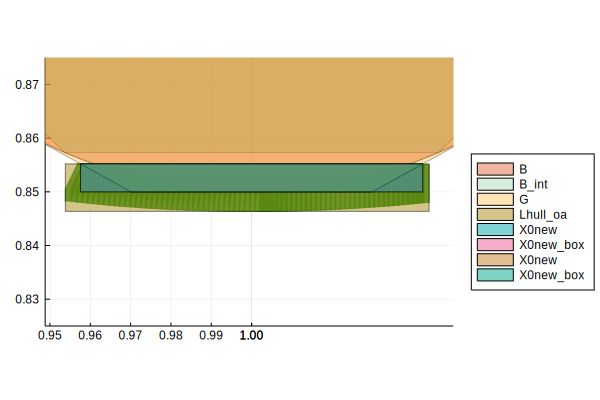

In [214]:
plot!(X0new, lab="X0new")
plot!(overapproximate(X0new, Hyperrectangle), lab="X0new_box", legend=:outerbottomright)

----

Now we compute the continuous post starting from `X0new`.

Regarding the time span of the solution, we have to shift the second flowpipe until the initial time of intersection.

In [254]:
prob = @ivp(x' = lotka_volterra!(x), dim: 2, x(0) ∈ X0new);
t0 = tstart(L)

sol2 = solve(prob, tspan=(0.0, 3.64 - t0), TMJets(abs_tol=1e-17,orderT=7,orderQ=1));
sol2z = overapproximate(sol2, Zonotope);
sol2z = shift(sol2z.F, t0);

sol_tot = HybridFlowpipe([solz.F, sol2z]); # final solution

-----

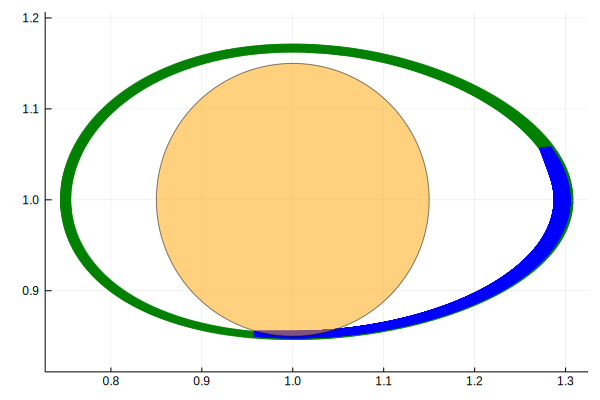

In [247]:
fig = plot()
plot!(fig, sol1z,  vars=(1, 2), linecolor=:green, color=:green, alpha=0.8, ratio=1.0)
plot!(fig, sol2z,  vars=(1, 2), linecolor=:blue, color=:blue, alpha=0.8, ratio=1.0)
plot!(B, 1e-4, color=:orange)